<a href="https://colab.research.google.com/github/Koks-creator/MovieRecommendation/blob/main/MovieRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Source:**<br>
<ul>
  <li>https://www.youtube.com/watch?v=G4MBc40rQ2k</li>
  <li>https://medium.com/@datadote/matrix-factorization-advanced-pictures-code-part-2-3072450879c1</li>
</ul>


In [1]:
! curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  2779k      0 --:--:-- --:--:-- --:--:-- 2785k


In [2]:
from typing import Tuple
from zipfile import ZipFile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import pickle

In [3]:
ZIP_PATH = r"/content/ml-latest-small.zip"
MOVIES_PATH = r"/content/data/ml-latest-small/movies.csv"
RATINGS_PATH = r"/content/data/ml-latest-small/ratings.csv"
NUM_WORKERS = 2
STOP_TRAINING_THRESH = 5
TRAIN_PERC = .8
MODEL_PATH = r"movieRecommendModel.pth"
MOVIE_MAPPING_PATH = r"MovieMapping.pkl"
ALREADY_RATED_PATH = "AlreadyRated.pkl"

EPOCHS = 30
BATCH_SIZE = 8192
# BATCH_SIZE = 64
DIM_SIZE = 32
LEARNING_RATE = 0.005
WEIGHT_DECAY = 0.0001

In [4]:
with ZipFile(ZIP_PATH) as zipf:
  zipf.extractall("data")

In [5]:
dfm = pd.read_csv(MOVIES_PATH)
df = pd.read_csv(RATINGS_PATH)
df = df.merge(dfm, on='movieId', how='left')
df = df.sort_values(['userId', 'timestamp'], ascending=[True, True]).reset_index(drop=True)
df.head(3)

,userId,movieId,rating,timestamp,title,genres
0,1,804,4.0,964980499,She's the One (1996),Comedy|Romance
1,1,1210,5.0,964980499,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2,1,2018,5.0,964980523,Bambi (1942),Animation|Children|Drama


In [6]:
users = df.userId.unique()
movies = df.movieId.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

idx2userid = {i:o for o,i in userid2idx.items()}
idx2movieid = {i:o for o,i in movieid2idx.items()}

df.movieId = df.movieId.apply(lambda x: movieid2idx[x])
df.userId = df.userId.apply(lambda x: userid2idx[x])

In [ ]:
df.head(3)

,userId,movieId,rating,timestamp,title,genres
0,0,0,4.0,964980499,She's the One (1996),Comedy|Romance
1,0,1,5.0,964980499,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2,0,2,5.0,964980523,Bambi (1942),Animation|Children|Drama


In [7]:
# Movie ID to movie name mapping
movie_names = df.set_index("movieId")["title"].to_dict()
n_users = len(df.userId.unique())
n_items = len(df.movieId.unique())

In [8]:
already_rated = {}
for user_id in range(n_users):
    rated_movies = df.loc[(df['userId'] == user_id)]["movieId"].unique().tolist()
    already_rated[user_id] = rated_movies

In [ ]:
list(movie_names.items())[:20]

[(0, "She's the One (1996)"),
 (1, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (2, 'Bambi (1942)'),
 (3, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (4, '13th Warrior, The (1999)'),
 (5, 'Gladiator (2000)'),
 (6, 'Road Trip (2000)'),
 (7, 'Shaft (2000)'),
 (8, 'Bottle Rocket (1996)'),
 (9, 'Dazed and Confused (1993)'),
 (10, 'American Beauty (1999)'),
 (11, 'Best Men (1997)'),
 (12, 'Being John Malkovich (1999)'),
 (13, 'Ed Wood (1994)'),
 (14, 'Swingers (1996)'),
 (15, 'Forrest Gump (1994)'),
 (16, 'Clerks (1994)'),
 (17, 'Grosse Pointe Blank (1997)'),
 (18, 'South Park: Bigger, Longer and Uncut (1999)'),
 (19, 'Rushmore (1998)')]

In [ ]:
class MovieDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        super().__init__()
        self.df = df[['userId', 'movieId', 'rating']]
        self.x_user_movie = list(zip(df.userId.values, df.movieId.values))
        self.y_rating = self.df.rating.values

    def __getitem__(self, idx: id):
        return torch.tensor(self.x_user_movie[idx]), torch.tensor(self.y_rating[idx])

    def __len__(self):
        return len(self.df)

In [ ]:
train_len = int(len(df) * TRAIN_PERC)
df_train = df[:train_len]
df_val = df[train_len:]

In [ ]:
print(len(df_train), len(df_val))

80668 20168


In [ ]:
ds_train = MovieDataset(df_train)
ds_val = MovieDataset(df_val)
train_loader = DataLoader(ds_train, BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(ds_val, BATCH_SIZE, shuffle=True, num_workers=2)

xb, yb = next(iter(train_loader))
print(xb)
print(yb)

tensor([[  83,  339],
        [  44, 2684],
        [ 234,  485],
        ...,
        [ 444,  749],
        [  35, 2493],
        [ 104, 1794]])
tensor([4.0000, 4.0000, 3.0000,  ..., 3.5000, 2.0000, 4.0000],
       dtype=torch.float64)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
def sigmoid_range(x, low, high):
    return torch.sigmoid(x) * (high - low) + low

In [ ]:
class MFAdvanced(nn.Module):
    """ Matrix factorization + user & item bias, weight init., sigmoid_range """
    def __init__(self, num_users, num_items, emb_dim, init, bias, sigmoid):
        super().__init__()
        self.bias = bias
        self.sigmoid = sigmoid
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)

        if bias:
            self.user_bias = nn.Parameter(torch.zeros(num_users))
            self.item_bias = nn.Parameter(torch.zeros(num_items))
            self.offset = nn.Parameter(torch.zeros(1))
        if init:
            self.user_emb.weight.data.uniform_(0., 0.05)
            self.item_emb.weight.data.uniform_(0., 0.05)

    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)

        element_product = (user_emb*item_emb).sum(1)

        if self.bias:
            user_b = self.user_bias[user]
            item_b = self.item_bias[item]
            element_product += user_b + item_b + self.offset
        if self.sigmoid:
            return sigmoid_range(element_product, 0, 5.5)
        return element_product

In [ ]:
CFG = {
    'sigmoid': True,
    'bias': True,
    'init': True,
}

In [ ]:
model = MFAdvanced(n_users, n_items, emb_dim=DIM_SIZE,
                 init=CFG['init'], # CFG=True
                 bias=CFG['bias'], # CFG=True
                 sigmoid=CFG['sigmoid'], # CFG=True
)
model.to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # weight_decay=WEIGHT_DECAY

In [ ]:
def round_to_0p5(list_nums):
    """ Helper func to round nums to nearest 0.5, eg 1.45 -> 1.5 """
    return np.round(np.array(list_nums)*2)/2

In [ ]:
def get_accuracy(model: MFAdvanced, data_loader: DataLoader, device: torch.device) -> float:
    whole_len = 0
    correct = 0
    with torch.no_grad():
        for (data, labels) in data_loader:
            user = data[:,0].to(device)
            item = data[:,1].to(device)
            labels = labels.to(device, dtype=torch.float)

            predictions = model(user, item)

            preds = round_to_0p5(predictions.tolist())
            labels = round_to_0p5(labels.tolist())

            results = [1 if pred-label < 0.5 else 0 for (pred, label) in zip(preds, labels)]

            correct += results.count(1)
            whole_len += len(results)

    return correct/whole_len * 100


In [ ]:
p_train_loss = 1000
p_val_loss = 1000
train_loss_count = 0
val_loss_count = 0

train_loss_hist = []
test_loss_hist = []
train_acc_hist = []
test_acc_hist = []


for epoch in range(EPOCHS):
    print(f"------------------- EPOCH {epoch+1}/{EPOCHS} -------------------")

    model.train()
    for (x, y) in tqdm(train_loader, total=len(train_loader)):
        user = x[:,0].to(device)
        item = x[:,1].to(device)
        y = y.to(device, dtype=torch.float)

        predictions = model(user, item)
        loss = loss_fn(predictions.squeeze(), y.float())

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_acc = get_accuracy(model, train_loader, device)

    if loss > p_train_loss:
          train_loss_count += 1
    else:
        train_loss_count = 0
    p_train_loss = loss

    train_loss_hist.append(loss.item())
    train_acc_hist.append(train_acc)

    model.eval()
    for (x, y) in tqdm(test_loader, total=len(test_loader)):
        user = x[:,0].to(device, dtype=torch.long)
        item = x[:,1].to(device, dtype=torch.long)
        y = y.to(device, dtype=torch.float)

        test_predictions = model(user, item)
        test_loss = loss_fn(test_predictions.squeeze(), y.float())

    test_acc = get_accuracy(model, test_loader, device)

    if test_loss > p_val_loss:
        val_loss_count += 1
    else:
        val_loss_count = 0
    p_val_loss = test_loss

    test_loss_hist.append(test_loss.item())
    test_acc_hist.append(test_acc)

    print(f'\nEpoch [{epoch+1}/{EPOCHS}] | Loss: {loss.item():.4f} | Test loss: {test_loss.item():.4f} | Acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')
    if train_loss_count == STOP_TRAINING_THRESH or val_loss_count == STOP_TRAINING_THRESH:
        print("Ending training...")
        break


------------------- EPOCH 1/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [1/30] | Loss: 1.2160 | Test loss: 1.3311 | Acc: 82.0648, Test acc: 77.9155
------------------- EPOCH 2/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [2/30] | Loss: 0.8519 | Test loss: 1.2404 | Acc: 69.6447, Test acc: 77.8163
------------------- EPOCH 3/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [3/30] | Loss: 0.7624 | Test loss: 1.1259 | Acc: 63.9907, Test acc: 77.4940
------------------- EPOCH 4/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [4/30] | Loss: 0.6926 | Test loss: 1.1442 | Acc: 62.9680, Test acc: 76.5073
------------------- EPOCH 5/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [5/30] | Loss: 0.6569 | Test loss: 1.1195 | Acc: 65.8749, Test acc: 76.8495
------------------- EPOCH 6/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [6/30] | Loss: 0.6738 | Test loss: 1.1292 | Acc: 67.1034, Test acc: 77.0924
------------------- EPOCH 7/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [7/30] | Loss: 0.6770 | Test loss: 1.1698 | Acc: 67.1406, Test acc: 77.1519
------------------- EPOCH 8/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [8/30] | Loss: 0.6256 | Test loss: 1.1256 | Acc: 67.3030, Test acc: 77.2709
------------------- EPOCH 9/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [9/30] | Loss: 0.6113 | Test loss: 1.1394 | Acc: 67.6315, Test acc: 77.2213
------------------- EPOCH 10/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [10/30] | Loss: 0.5993 | Test loss: 1.1812 | Acc: 68.0121, Test acc: 77.2065
------------------- EPOCH 11/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [11/30] | Loss: 0.5687 | Test loss: 1.1695 | Acc: 68.4559, Test acc: 77.1668
------------------- EPOCH 12/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [12/30] | Loss: 0.5442 | Test loss: 1.1531 | Acc: 69.0993, Test acc: 77.1569
------------------- EPOCH 13/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [13/30] | Loss: 0.5302 | Test loss: 1.1299 | Acc: 69.5778, Test acc: 77.1271
------------------- EPOCH 14/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [14/30] | Loss: 0.4898 | Test loss: 1.1468 | Acc: 70.3265, Test acc: 77.0875
------------------- EPOCH 15/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [15/30] | Loss: 0.4673 | Test loss: 1.1726 | Acc: 71.2178, Test acc: 77.0627
------------------- EPOCH 16/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [16/30] | Loss: 0.4323 | Test loss: 1.1695 | Acc: 72.0521, Test acc: 77.0577
------------------- EPOCH 17/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [17/30] | Loss: 0.4211 | Test loss: 1.1392 | Acc: 72.9831, Test acc: 77.1073
------------------- EPOCH 18/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [18/30] | Loss: 0.3897 | Test loss: 1.1377 | Acc: 73.8508, Test acc: 77.0875
------------------- EPOCH 19/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [19/30] | Loss: 0.3390 | Test loss: 1.1638 | Acc: 74.7731, Test acc: 77.0825
------------------- EPOCH 20/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [20/30] | Loss: 0.3093 | Test loss: 1.1712 | Acc: 75.7351, Test acc: 77.0428
------------------- EPOCH 21/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [21/30] | Loss: 0.2929 | Test loss: 1.1490 | Acc: 76.5285, Test acc: 77.0825
------------------- EPOCH 22/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [22/30] | Loss: 0.2604 | Test loss: 1.1601 | Acc: 77.3814, Test acc: 77.0875
------------------- EPOCH 23/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [23/30] | Loss: 0.2501 | Test loss: 1.1762 | Acc: 78.1859, Test acc: 77.0726
------------------- EPOCH 24/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [24/30] | Loss: 0.2299 | Test loss: 1.1834 | Acc: 78.9917, Test acc: 77.1172
------------------- EPOCH 25/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [25/30] | Loss: 0.2084 | Test loss: 1.1854 | Acc: 79.7094, Test acc: 77.0875
------------------- EPOCH 26/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [26/30] | Loss: 0.1972 | Test loss: 1.1640 | Acc: 80.3652, Test acc: 77.1073
------------------- EPOCH 27/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [27/30] | Loss: 0.1757 | Test loss: 1.1416 | Acc: 80.9850, Test acc: 77.0974
------------------- EPOCH 28/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [28/30] | Loss: 0.1731 | Test loss: 1.1652 | Acc: 81.5701, Test acc: 77.0875
------------------- EPOCH 29/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [29/30] | Loss: 0.1574 | Test loss: 1.1834 | Acc: 82.0871, Test acc: 77.0032
------------------- EPOCH 30/30 -------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch [30/30] | Loss: 0.1418 | Test loss: 1.1675 | Acc: 82.5842, Test acc: 77.0081


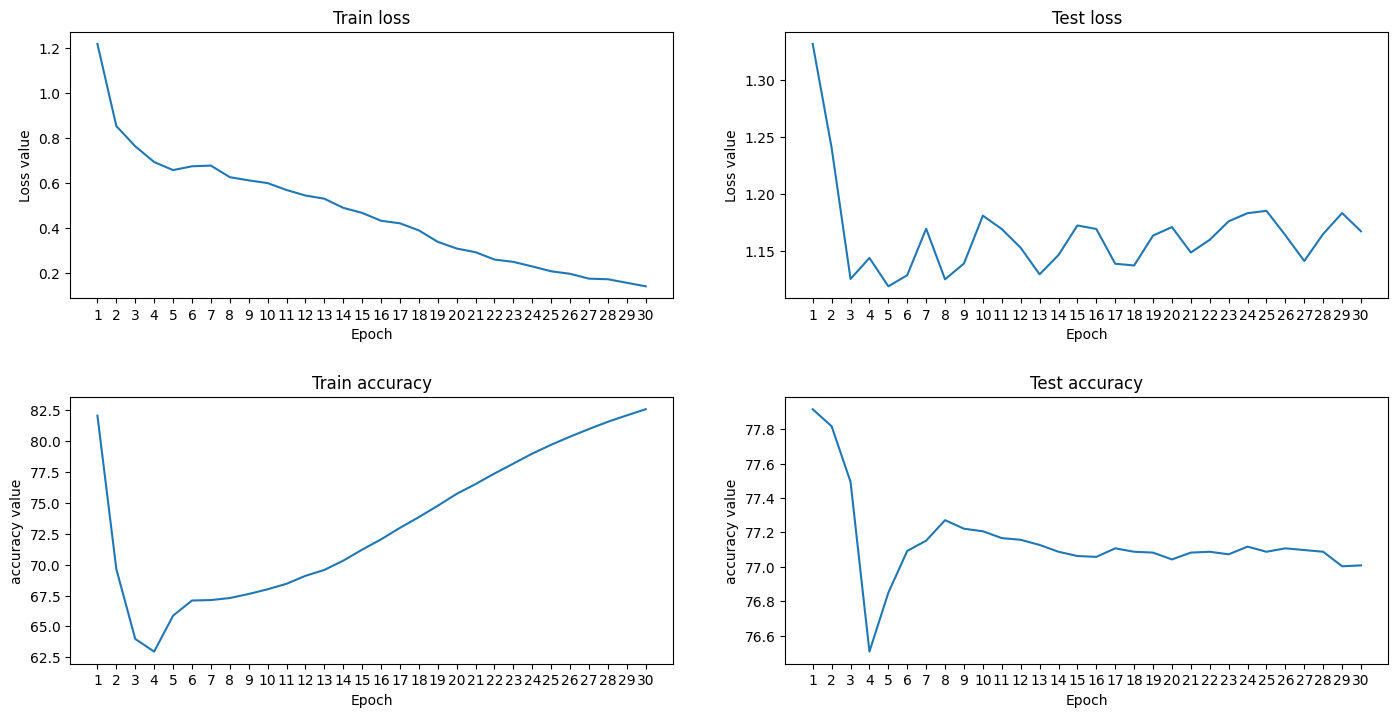

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
fig.tight_layout(pad=5.0)
plt.setp(ax, xticks=[i for i in range(EPOCHS)], xticklabels=[i+1 for i in range(EPOCHS)])


ax[0][0].plot(train_loss_hist, label="Train loss")
ax[0][0].set_title("Train loss")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Loss value")

ax[0][1].plot(test_loss_hist, label="Test loss")
ax[0][1].set_title("Test loss")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Loss value")


ax[1][0].plot(train_acc_hist, label="Train accuracy")
ax[1][0].set_title("Train accuracy")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("accuracy value")

ax[1][1].plot(test_acc_hist, label="Test accuracy")
ax[1][1].set_title("Test accuracy")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("accuracy value")

plt.show()

**Testing**

In [ ]:
model.eval()

MFAdvanced(
  (user_emb): Embedding(610, 32)
  (item_emb): Embedding(9724, 32)
)

In [ ]:
user_id = 1
user_ratings = []

for item_id in range(n_items):
    predicted_rating = model(torch.tensor([user_id]).to(device), torch.tensor([item_id]).to(device))
    user_ratings.append((item_id, predicted_rating))

user_ratings.sort(key=lambda x: x[1], reverse=True)

top_n = 10
recommended_movies = user_ratings[:top_n]

for i, (item_id, predicted_rating) in enumerate(recommended_movies):
  try:
    print(f"Recommendation {i + 1}: Movie {movie_names[item_id]} - Predicted Rating: {predicted_rating}")
  except KeyError:
    pass

Recommendation 1: Movie The Jinx: The Life and Deaths of Robert Durst (2015) - Predicted Rating: tensor([4.7791], device='cuda:0', grad_fn=<AddBackward0>)
Recommendation 2: Movie Adam's Rib (1949) - Predicted Rating: tensor([4.6067], device='cuda:0', grad_fn=<AddBackward0>)
Recommendation 3: Movie Evil Dead II (Dead by Dawn) (1987) - Predicted Rating: tensor([4.5979], device='cuda:0', grad_fn=<AddBackward0>)
Recommendation 4: Movie Inside Job (2010) - Predicted Rating: tensor([4.5844], device='cuda:0', grad_fn=<AddBackward0>)
Recommendation 5: Movie Shallow Grave (1994) - Predicted Rating: tensor([4.5680], device='cuda:0', grad_fn=<AddBackward0>)
Recommendation 6: Movie About Time (2013) - Predicted Rating: tensor([4.5418], device='cuda:0', grad_fn=<AddBackward0>)
Recommendation 7: Movie Big Sleep, The (1946) - Predicted Rating: tensor([4.5417], device='cuda:0', grad_fn=<AddBackward0>)
Recommendation 8: Movie Three Billboards Outside Ebbing, Missouri (2017) - Predicted Rating: tensor([

In [ ]:
def predict_user_rating(user_id: int, movie_name: str) -> Tuple[float, float]:
    user_record = df.loc[(df['userId'] == user_id) & (df['title'] == movie_name)][["title", "rating", "movieId"]]
    user_rating = user_record["rating"].item()
    movie_id =  user_record["movieId"].item()

    predicted_rating = model(torch.tensor([user_id]).to(device), torch.tensor([movie_id]).to(device))
    return round_to_0p5([predicted_rating.item()])[0], user_rating

In [ ]:
user_id = 1
movie_name = "Ex Machina (2015)"

print(predict_user_rating(1, movie_name))

(3.5, 3.5)


**Save model**

In [9]:
torch.save(model.state_dict(), MODEL_PATH)

with open(MOVIE_MAPPING_PATH, "wb") as mmf:
    pickle.dump(movie_names, mmf)

with open(ALREADY_RATED_PATH, "wb") as arf:
    pickle.dump(already_rated, arf)

In [ ]:
load_model = MFAdvanced(n_users, n_items, emb_dim=DIM_SIZE,
                 init=CFG['init'], # CFG=True
                 bias=CFG['bias'], # CFG=True
                 sigmoid=CFG['sigmoid'], # CFG=True
)
load_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))  # Choose whatever GPU device number you want
load_model.to(device)

MFAdvanced(
  (user_emb): Embedding(610, 32)
  (item_emb): Embedding(9724, 32)
)

In [ ]:
predicted_rating = load_model(torch.tensor([1]).to(device), torch.tensor([235]).to(device))

In [ ]:
predicted_rating

tensor([3.6776], device='cuda:0', grad_fn=<AddBackward0>)